# PyTorch Regression Tutorial

This tutorial demonstrates how to:
1. Set up a regression problem in PyTorch
2. Implement proper data splitting
3. Create a neural network model
4. Implement early stopping
5. Train and evaluate the model

## Setup
First, let's import our required libraries:

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

## 1. Data Generation
 
For this tutorial, we'll create synthetic data with some noise to simulate a real-world regression problem.
The true relationship is: y = 2.5x + sin(x) + noise

In [2]:
np.random.seed(42)
X = np.linspace(-5, 5, 200).reshape(-1, 1)
y = 2.5 * X + np.sin(X) + np.random.normal(0, 0.2, (200, 1))

## 2. Dataset Creation
 
PyTorch requires a Dataset class to handle data efficiently. This class will:
- Convert numpy arrays to PyTorch tensors
- Provide access to individual samples
- Enable the use of DataLoader for batch processing

In [3]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## 3. Model Definition
 
We'll create a simple neural network with:
- Two hidden layers (16 neurons each)
- ReLU activation functions
- A single output neuron for regression

In [4]:
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.network(x)

## 4. Early Stopping Implementation
 
Early stopping helps prevent overfitting by:
- Monitoring validation loss
- Stopping training when performance stops improving
- Saving the best model weights

In [5]:
class EarlyStopping:
    def __init__(self, patience: int = 7, min_delta: float = 0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False
        self.best_model = None
    
    def __call__(self, model: nn.Module, val_loss: float) -> bool:
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0
        
        return self.should_stop

## 5. Training Function
 
This function handles:
- Training loop with batches
- Validation phase
- Loss tracking
- Early stopping checks

In [6]:
def train_model(model: nn.Module, 
                train_loader: DataLoader,
                val_loader: DataLoader,
                criterion: nn.Module,
                optimizer: torch.optim.Optimizer,
                epochs: int = 100) -> Tuple[List[float], List[float]]:
    
    train_losses = []
    val_losses = []
    early_stopping = EarlyStopping(patience=10)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch).item()
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss = {train_loss:.4f}, '
                  f'Val Loss = {val_loss:.4f}')
        
        # Early stopping check
        if early_stopping(model, val_loss):
            print(f'Early stopping triggered at epoch {epoch}')
            model.load_state_dict(early_stopping.best_model)
            break
    
    return train_losses, val_losses

## 6. Data Preparation

Let's split our data into:
- Training set (70%)
- Validation set (15%)
- Test set (15%)

In [7]:
dataset = SimpleDataset(X, y)

# Split data
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


## 7. Model Training
 
Initialize the model, loss function, and optimizer, then train the model:


In [8]:
model = RegressionModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer
)

# %% [markdown]
# ## 8. Model Evaluation
# 
# Let's evaluate our model on the test set:

# %%
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        test_loss += criterion(y_pred, y_batch).item()
        test_predictions.extend(y_pred.numpy())
        test_targets.extend(y_batch.numpy())
    
test_loss /= len(test_loader)
print(f'\nTest Loss: {test_loss:.4f}')

Epoch 0: Train Loss = 46.2751, Val Loss = 52.4823
Epoch 10: Train Loss = 1.2088, Val Loss = 1.1006
Epoch 20: Train Loss = 0.1223, Val Loss = 0.1011
Epoch 30: Train Loss = 0.0822, Val Loss = 0.0656
Epoch 40: Train Loss = 0.0654, Val Loss = 0.0501
Epoch 50: Train Loss = 0.0630, Val Loss = 0.0425
Epoch 60: Train Loss = 0.0534, Val Loss = 0.0375
Epoch 70: Train Loss = 0.0489, Val Loss = 0.0328
Epoch 80: Train Loss = 0.0470, Val Loss = 0.0305
Early stopping triggered at epoch 81

Test Loss: 0.0310


## 9. Visualization
 
Let's create three plots to visualize our results:
1. Training and validation loss curves
2. Model predictions on the entire dataset
3. Test set predictions vs true values

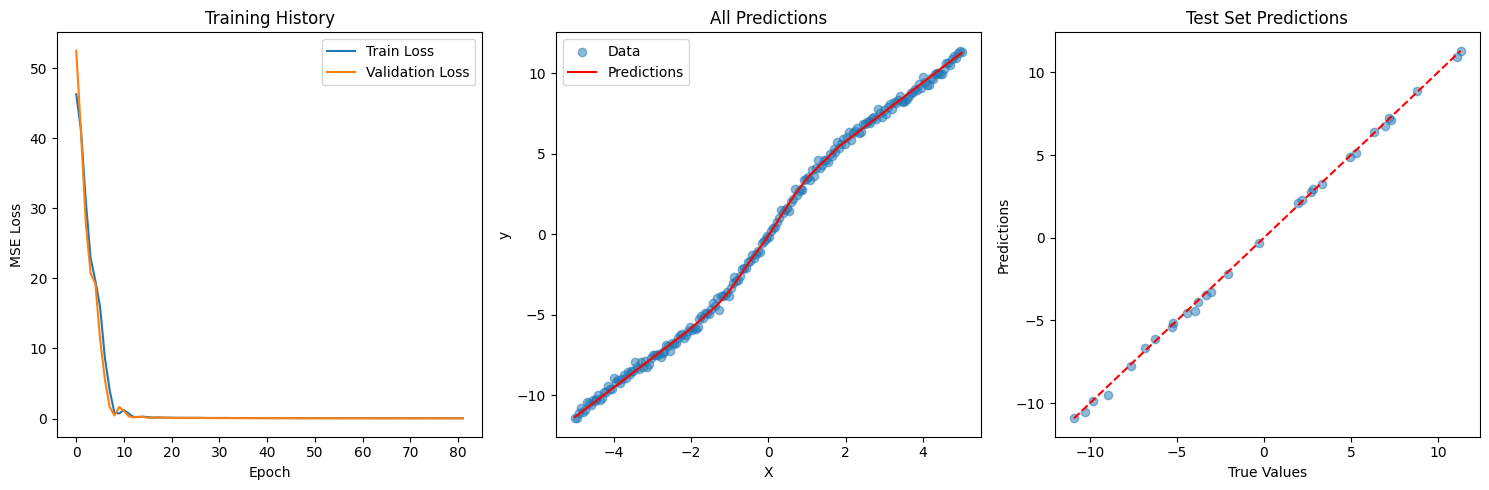

In [9]:
plt.figure(figsize=(15, 5))

# Plot training and validation loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Plot all predictions
plt.subplot(1, 3, 2)
model.eval()
with torch.no_grad():
    X_tensor = torch.FloatTensor(X)
    y_pred = model(X_tensor).numpy()

plt.scatter(X, y, alpha=0.5, label='Data')
plt.plot(X, y_pred, 'r', label='Predictions')
plt.title('All Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

# Plot test set predictions
plt.subplot(1, 3, 3)
plt.scatter(test_targets, test_predictions, alpha=0.5)
plt.plot([min(test_targets), max(test_targets)], 
         [min(test_targets), max(test_targets)], 'r--')
plt.title('Test Set Predictions')
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.tight_layout()
plt.show()

## Next Steps
 
To improve this model, you could:
1. Add data normalization
2. Implement k-fold cross-validation
3. Add learning rate scheduling
4. Try different network architectures
5. Add dropout layers for regularization
6. Implement model checkpointing